# Benchmark - Run-Time

This notebook shows how to perform the run-time checks showcased in the paper.

**Note**: Depending on the hardware + software version, the values obtained might differ from those shown on the paper; It takes a considerable amount of time to run these tests.

**Requirements**: Download Pre-trained Models

In [1]:
import os
import jax
import sys
import glob
import pickle
import numpy as np
import jax.numpy as jnp

from pathlib import Path
from tqdm.auto import tqdm
from time import time

# uncomment the line below for nicer plots (needs LaTeX)
# os.environ['MATPLOTLIBRC'] = '../matplotlibrc'
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

sys.path.append('../..')
from gns.simulator import SMGNS
from sheet_model.synchronous import SyncSheetModel
from sheet_model.modified import ModSyncSheetModel
from sheet_model.asynchronous import AsyncSheetModel
from sheet_model.utils import get_dx_eq, get_x_eq

In [2]:
def run_time_sm(lambda_v, opt, modified=False):
    """
    Aux function to compute run-time of synchrnous sheet model.
    
    Args:
        lambda_v - function that generates array of input velocities
        opt - sheet model simulation parameters
        modified - use modified sync implementation
        
    Returns:
        results - dict with run-time mean + std over multiple simulations
    """
    results = {'mean': [], 'std': []}
    
    # reproducibility + same random as GNN
    np.random.seed(42) 

    # store only every dt=1e-1
    dt_undersample = max(1, np.ceil(dt/DT_MAX))
    
    if modified:
        sim = ModSyncSheetModel(**opt)
    else:
        sim = SyncSheetModel(**opt)
                 
    for v_th in V_TH:

        print('v_th:', v_th)
        
        dT = []
        
        for i in tqdm(range(N_SIMULATIONS)):
            
            v0 = lambda_v(v_th)
            
            try:
                start = time()
                _, _, _, _ = sim.run_simulation(x_0=x0,
                                                v_0=v0,
                                                x_eq_0=x_eq,
                                                t_max=t_max,
                                                dt_undersample=dt_undersample,
                                                verbose=False)


                end = time()
                dT.append(end-start)
                
            except Exception as e:
                print(e)

        results['mean'].append(np.mean(dT))
        results['std'].append(np.std(dT))
        
    return results


def run_time_asm(lambda_v, opt):
    """
    Aux function to compute run-time of asynchrnous sheet model.
    
    Args:
        lambda_v - function that generates array of input velocities
        opt - sheet model simulation parameters
        
    Returns:
        results - dict with run-time mean + std over multiple simulations
    """
    results = {'mean': [], 'std': []}
    
    # reproducibility + same random as GNN
    np.random.seed(42) 

    sim = AsyncSheetModel(L=opt['L'],
                          boundary=opt['boundary'],
                          track_sheets=opt['track_sheets'])
    
    for v_th in V_TH:

        print('v_th:', v_th)
        
        dT = []
        
        for i in tqdm(range(N_SIMULATIONS)):
            
            v0 = lambda_v(v_th)
            
            try:
                start = time()
                _ = sim.run_simulation(x_0=x0,
                                       v_0=v0,
                                       x_eq_0=x_eq,
                                       t_max=t_max,
                                       verbose=False)


                end = time()
                dT.append(end-start)
                
            except Exception as e:
                print(e)

        results['mean'].append(np.mean(dT))
        results['std'].append(np.std(dT))
        
    return results
    

def run_time_gns(lambda_v, opt):
    """
    Aux function to compute run-time of GNS.
    
    Args:
        lambda_v - function that generates array of input velocities
        opt - sheet model simulation parameters
        
    Returns:
        results - dict with run-time mean + std over multiple simulations
        t_jit_compile - jit compile time
    """
    results = {'mean': [], 'std': []}
    
    # reproducibility + same random as GNN
    np.random.seed(42) 
    dt_undersample = max(1, np.ceil(dt/DT_MAX))
    
    # load model
    model_folder = Path('../../models/final/dt{0:.0e}/0'.format(opt['dt']).replace('e-0', 'e-'))
    gns = SMGNS(model_folder, opt['boundary'], verbose=False)
    
    # dummy sim to get jit compile time
    start = time()
    _, _, _, _ = gns.pred_rollout(x0, 
                                  np.zeros_like(x0),
                                  x_eq,
                                  dt_undersample=dt_undersample,
                                  t_max=gns.dt_train,
                                  n_guards=0,
                                  verbose=False,
                                  track_sheets=False,
                                  np_=np)

    t_jit_compile = time() - start

            
    for v_th in V_TH:

        print('v_th:', v_th)
        
        dT = []

        for i in tqdm(range(N_SIMULATIONS)):
            
            v0 = lambda_v(v_th)
            
            start = time()
            _, _, _, _ = gns.pred_rollout(x0, 
                                          v0,
                                          x_eq,
                                          dt_undersample=dt_undersample,
                                          t_max=t_max,
                                          n_guards=0,
                                          verbose=False,
                                          track_sheets=False,
                                          np_=np)
            
            end = time()
            dT.append(end-start)
            

        results['mean'].append(np.mean(dT))
        results['std'].append(np.std(dT))
    
    return results, t_jit_compile

## Sheet Model

In [3]:
# ----------------------------------
# Default Options
opt = {
    'n_guards' : 20, # number of guards
    'n_sheets' : 1000, #number of sheets
    'dt' : None, # simulation dt [1/w_p]
    'boundary' : 'periodic', # type (periodic or reflecting)
    'n_it_crossings' : None, # number of iterations used to solve crossings
    'track_sheets': False,
    'L': 1
}

t_max = 2*np.pi

dx_eq = get_dx_eq(opt['n_sheets'], opt['L']) 
x_eq = get_x_eq(opt['n_sheets'], opt['L'])
x0 = x_eq

V_TH = np.logspace(0,2,10) # v_th values to check
DT_MAX = 0.1
N_SIMULATIONS = 5

lambda_v_thermal = lambda v_th : np.random.normal(0, v_th, opt['n_sheets']) * dx_eq

### Run-time in function of n_it_crossings

In [4]:
results_nitc = dict()
N_IT_CROSSINGS = range(4)

for dt in [1e-1, 1e-2]:
    results_nitc[dt] = dict()
    for n in N_IT_CROSSINGS:
        print(dt, n)
        aux = opt.copy()
        aux['dt'] = dt
        aux['n_it_crossings'] = n
        results_nitc[dt][n] = run_time_sm(lambda_v_thermal, aux)

0.1 0
v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

Sheet crossed all guards - Increase n_guards or decrease dt
Sheet crossed all guards - Increase n_guards or decrease dt
0.1 1
v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

Sheet crossed all guards - Increase n_guards or decrease dt
Sheet crossed all guards - Increase n_guards or decrease dt
Sheet crossed all guards - Increase n_guards or decrease dt
0.1 2
v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

Sheet crossed all guards - Increase n_guards or decrease dt
Sheet crossed all guards - Increase n_guards or decrease dt
Sheet crossed all guards - Increase n_guards or decrease dt
Sheet crossed all guards - Increase n_guards or decrease dt
0.1 3
v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

Sheet crossed all guards - Increase n_guards or decrease dt
Sheet crossed all guards - Increase n_guards or decrease dt
Sheet crossed all guards - Increase n_guards or decrease dt
Sheet crossed all guards - Increase n_guards or decrease dt
0.01 0
v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

0.01 1
v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

0.01 2
v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

0.01 3
v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

### Run-time in function of n_neighbors checked (modified SM)

In [5]:
results_neighbors = dict()
N_NEIGHBORS = range(1,8)

for dt in [1e-1, 1e-2]:
    results_neighbors[dt] = dict()
    for n in N_NEIGHBORS:
        if (dt == 1e-1 and n % 2 == 1) or (dt == 1e-2 and n <= 3):
            print(dt, n)
            aux = opt.copy()
            aux['dt'] = dt
            aux['n_it_crossings'] = 2
            aux['n_max_neighbor'] = n
            results_neighbors[dt][n] = run_time_sm(lambda_v_thermal, aux, modified=True)

0.1 1
v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

Sheet crossed all guards - Increase n_guards or decrease dt
Sheet crossed all guards - Increase n_guards or decrease dt
0.1 3
v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

Sheet crossed all guards - Increase n_guards or decrease dt
0.1 5
v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

Sheet crossed all guards - Increase n_guards or decrease dt
Sheet crossed all guards - Increase n_guards or decrease dt
0.1 7
v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

Sheet crossed all guards - Increase n_guards or decrease dt
v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

Sheet crossed all guards - Increase n_guards or decrease dt
Sheet crossed all guards - Increase n_guards or decrease dt
Sheet crossed all guards - Increase n_guards or decrease dt
0.01 1
v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

0.01 2
v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

0.01 3
v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

### Asynchronous

In [6]:
results_async = run_time_asm(lambda_v_thermal, opt)

v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

# GNS

In [7]:
t_jit_compile = dict()
results_gns = dict()

aux = opt.copy()

for dt in [1e-1, 1e-2]:    
    aux['dt'] = dt
    results_gns[dt], t_jit_compile[dt] = run_time_gns(lambda_v_thermal, aux)

v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/5 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/5 [00:00<?, ?it/s]

# Save results

In [8]:
with open('benchmark_runtime.pkl', 'wb') as f:
    
    benchmark_energy = {
        'nitc': results_nitc,
        'neighbors': results_neighbors,
        'async': results_async,
        'gns': results_gns,
        't_jit_compile': t_jit_compile
    }
    
    pickle.dump(benchmark_energy, f)

# Load results

In [9]:
with open('benchmark_runtime.pkl', 'rb') as f:
    benchmark_energy = pickle.load(f)
    results_nitc = benchmark_energy['nitc']
    results_neighbors = benchmark_energy['neighbors']
    results_async = benchmark_energy['async']
    results_gns = benchmark_energy['gns']
    t_jit_compile = benchmark_energy['t_jit_compile']

# Plot Results

In [10]:
t_jit_compile

{0.1: 2.339359760284424, 0.01: 1.1973249912261963}

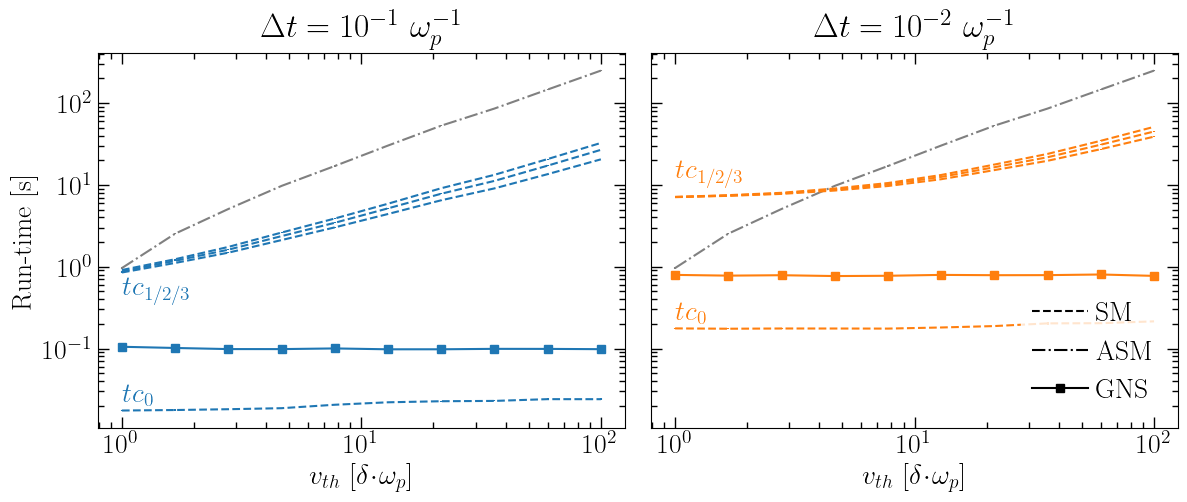

In [11]:
colors = {1e-1: 'tab:blue', 1e-2: 'tab:orange'}#, 1e-3: 'tab:green'}

fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, 
                       gridspec_kw={'wspace': 0.05, 'bottom': 0.15, 'top': 0.90, 'left': 0.09, 'right': 0.99})


for i, dt in enumerate(results_nitc):
    ax[i].errorbar(V_TH, np.array(results_async['mean']), yerr=np.array(results_async['std'])/np.sqrt(N_SIMULATIONS), 
                   ls='-.', color='grey')
    

for i, (dt, rt) in enumerate(results_nitc.items()):
    for n, r in rt.items():
        ax[i].errorbar(V_TH, np.array(r['mean']), yerr=np.array(r['std'])/np.sqrt(N_SIMULATIONS), 
                       ls='--', color=colors[dt])


for i, (dt, r) in enumerate(results_gns.items()):
    ax[i].errorbar(V_TH, np.array(r['mean']), yerr=np.array(r['std'])/np.sqrt(N_SIMULATIONS), 
                   marker='s', color=colors[dt])

handles = []
handles.append(mlines.Line2D([], [], color='k', linestyle='--', label='SM'))
handles.append(mlines.Line2D([], [], color='k', linestyle='-.', label='ASM'))
handles.append(mlines.Line2D([], [], color='k', linestyle='-', marker='s', label='GNS'))
plt.legend(handles=handles, fontsize=20, framealpha=0.8, loc='lower right')

plt.setp(ax, xlabel='$v_{th}$ [$\delta\!\cdot\!\omega_p$]')
ax[0].set_ylabel('Run-time [s]')
ax[0].set_title('$\Delta t = 10^{-1} \ \omega_p^{-1}$', pad=12)
ax[1].set_title('$\Delta t = 10^{-2} \ \omega_p^{-1}$', pad=12)

plt.yscale('log')
plt.xscale('log')

ax[0].text(1, results_nitc[1e-1][0]['mean'][0] + 0.5e-2, '$tc_0$', fontsize=20, color='tab:blue') 
ax[0].text(1, results_nitc[1e-1][1]['mean'][0] - 0.4, '$tc_{1/2/3}$', fontsize=20, color='tab:blue') 

ax[1].text(1, results_nitc[1e-2][0]['mean'][0] + 0.5e-1, '$tc_0$', fontsize=20, color='tab:orange') 
ax[1].text(1, results_nitc[1e-2][1]['mean'][0] + 5, '$tc_{1/2/3}$', fontsize=20, color='tab:orange') 


plt.savefig('../img/benchmark_runtime_nitc.pdf')
plt.show()

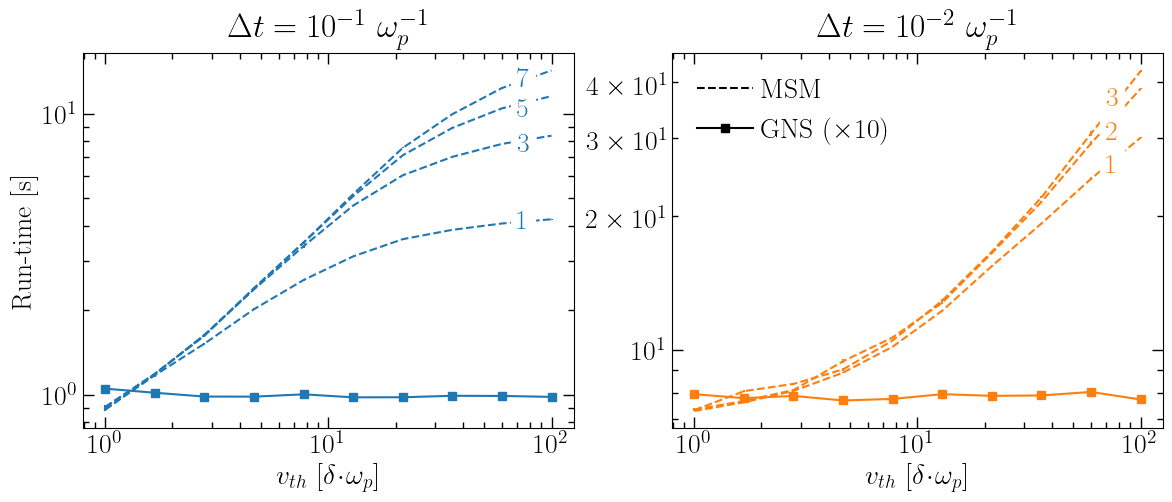

In [12]:
colors = {1e-1: 'tab:blue', 1e-2: 'tab:orange'}

fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=False, 
                       gridspec_kw={'wspace': 0.2, 'bottom': 0.15, 'top': 0.90, 'left': 0.09, 'right': 0.99})

for i, (dt, rt) in enumerate(results_neighbors.items()):
    for n, r in rt.items():
        ax[i].errorbar(V_TH, np.array(r['mean']), yerr=np.array(r['std'])/np.sqrt(N_SIMULATIONS), 
                       ls='--', color=colors[dt])

    
for i, (dt, r) in enumerate(results_gns.items()):
    ax[i].errorbar(V_TH, np.array(r['mean'])*10, yerr=np.array(r['std'])/np.sqrt(N_SIMULATIONS), 
                   marker='s', color=colors[dt])

handles = []
handles.append(mlines.Line2D([], [], color='k', linestyle='--', label='MSM'))
handles.append(mlines.Line2D([], [], color='k', linestyle='-', marker='s', label=r'GNS ($\times 10$)'))
plt.legend(handles=handles, fontsize=20, framealpha=0.8, loc='upper left')

plt.setp(ax, xlabel='$v_{th}$ [$\delta\!\cdot\!\omega_p$]')
ax[0].set_ylabel('Run-time [s]')
ax[0].set_title('$\Delta t = 10^{-1} \ \omega_p^{-1}$', pad=12)
ax[1].set_title('$\Delta t = 10^{-2} \ \omega_p^{-1}$', pad=12)

plt.setp(ax, yscale='log')
plt.setp(ax, xscale='log')

ax[0].text(70, results_neighbors[1e-1][1]['mean'][-1] - 0.3, '1', fontsize=20, color='tab:blue', bbox={'color': 'white'}) 
ax[0].text(70, results_neighbors[1e-1][3]['mean'][-1] - 1, '3', fontsize=20, color='tab:blue', bbox={'color': 'white'}) 
ax[0].text(70, results_neighbors[1e-1][5]['mean'][-1] - 1.8, '5', fontsize=20, color='tab:blue', bbox={'color': 'white'}) 
ax[0].text(70, results_neighbors[1e-1][7]['mean'][-1] - 1.8, '7', fontsize=20, color='tab:blue', bbox={'color': 'white'}) 
ax[1].text(70, results_neighbors[1e-2][1]['mean'][-1] - 5, '1', fontsize=20, color='tab:orange', bbox={'color': 'white'}) 
ax[1].text(70, results_neighbors[1e-2][2]['mean'][-1] - 9, '2', fontsize=20, color='tab:orange', bbox={'color': 'white'}) 
ax[1].text(70, results_neighbors[1e-2][3]['mean'][-1] - 7, '3', fontsize=20, color='tab:orange', bbox={'color': 'white'}) 

plt.savefig('../img/benchmark_runtime_neighbors.pdf')
plt.show()